# VEHICLE DETECTION

**Goals**

The goals / steps of this project are the following:

* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
* Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector. 
* Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.


### Importing utilities

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
from skimage.feature import hog
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from scipy.ndimage.measurements import label
%matplotlib inline

### Loading and displaying images from training data set

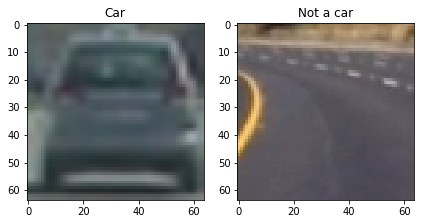

In [2]:

cars = glob.glob('./vehicles/vehicles/**/*.png')
not_cars = glob.glob('./non-vehicles/non-vehicles/**/*.png')

car_img = mpimg.imread(cars[3])
non_car_img = mpimg.imread(not_cars[3])
fig = plt.figure()
plt.subplot(121)
plt.imshow(car_img)
plt.title('Car')
plt.subplot(122)
plt.imshow(non_car_img)
plt.title('Not a car')
fig.tight_layout()

## HOG Features

**1. Explain how (and identify where in your code) you extracted HOG features from the training images.**

The below cell contains function to extract Histogram of Oriented Gradients(HOG) features from training image.
The function is taken from udacity classroom material.
The HOG features of training images were calculated using extract_features function. All the color channel of the image was used for extracting HOG features.

In [3]:
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), block_norm= 'L2-Hys',
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), block_norm= 'L2-Hys',
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features



### Example of extracting HOG Features from test images

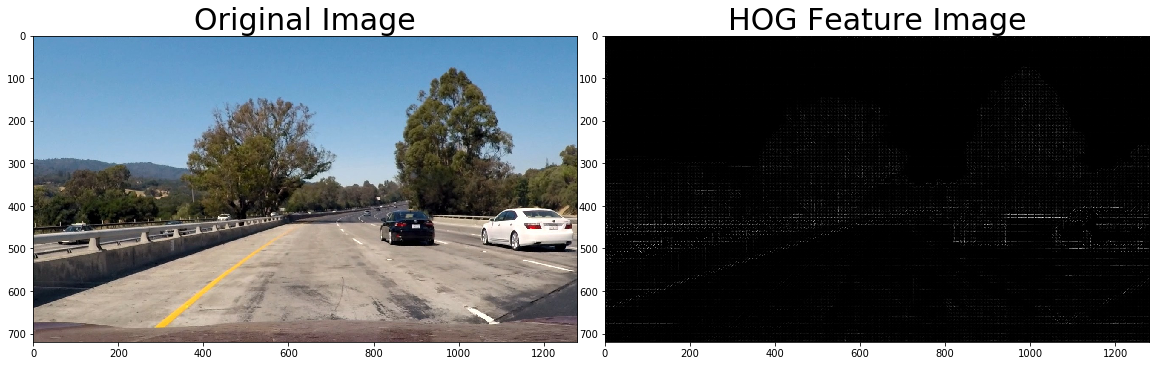

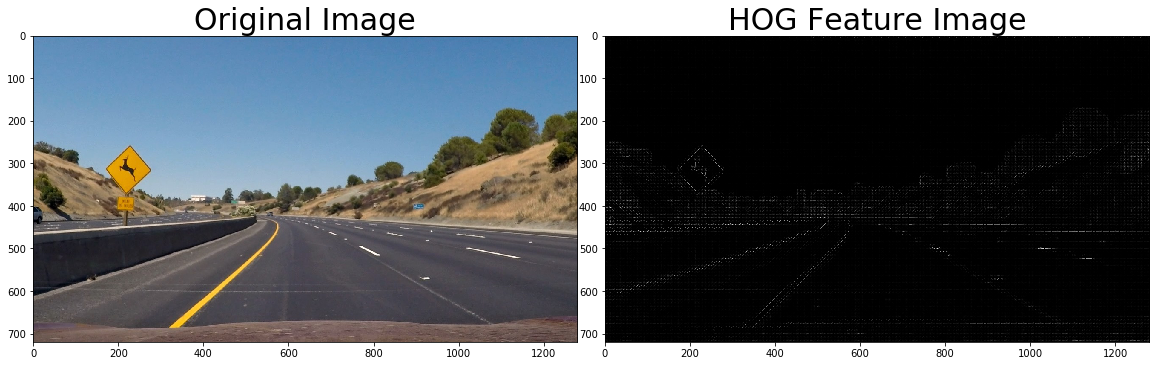

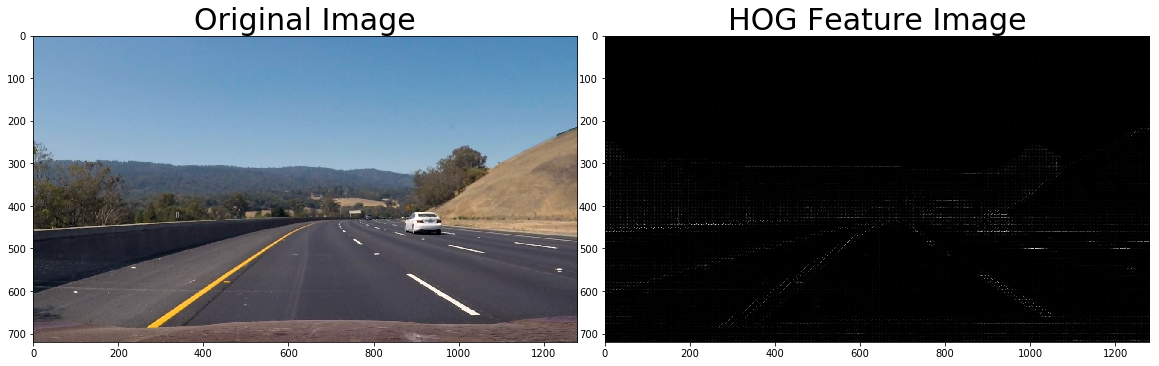

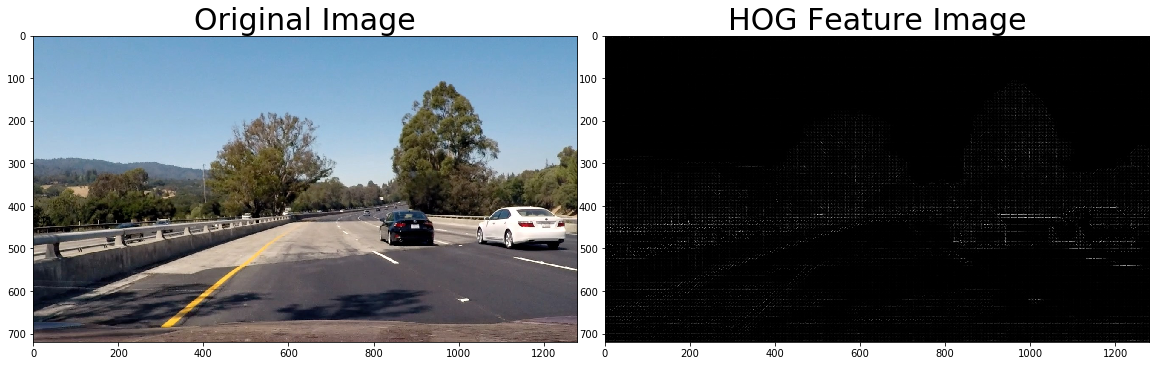

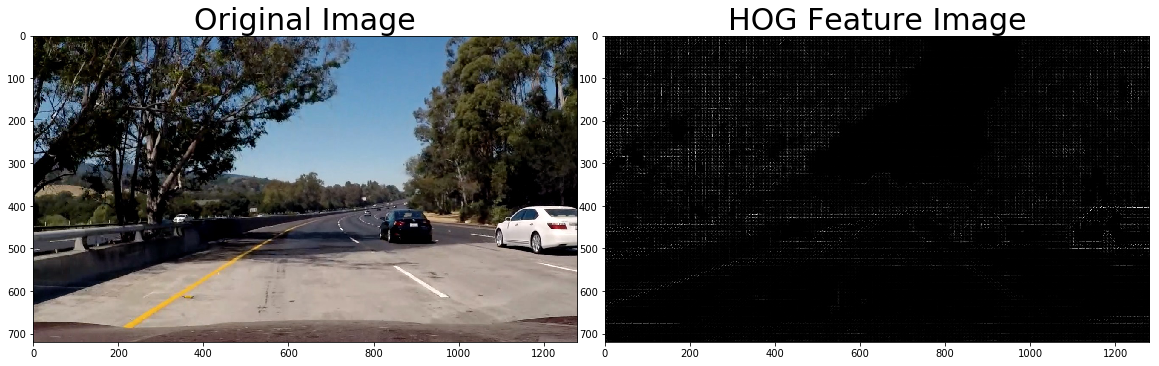

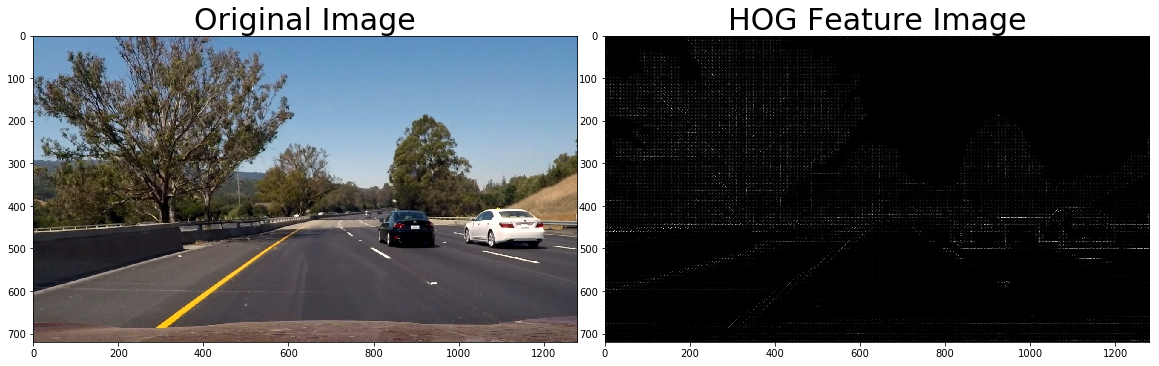

In [4]:
orient = 8
pix_per_cell = 8
cell_per_block = 2

test_images = glob.glob('./test_images/*.jpg')
for fname in test_images:
    test_image = mpimg.imread(fname)
    hog_image = cv2.cvtColor(test_image,cv2.COLOR_RGB2YCrCb)
    hog_features,output_img = get_hog_features(hog_image[:,:,0],orient, pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=True)
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    f.subplots_adjust(hspace = .2, wspace=.05)
    ax1.imshow(test_image)
    ax1.set_title('Original Image', fontsize=30)
    ax2.imshow(output_img)
    ax2.set_title('HOG Feature Image', fontsize=30)
    plt.imshow(output_img,cmap='gray')

### Example of extracting HOG Features from Training images

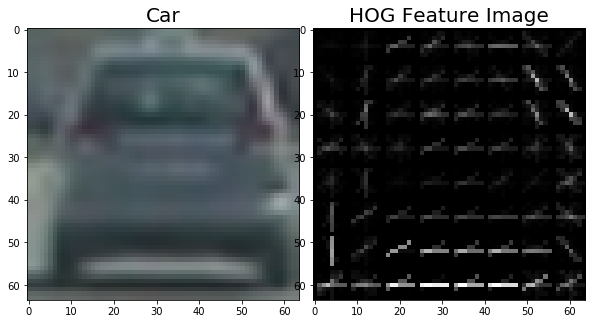

In [5]:
car_img = mpimg.imread(cars[3])
hog_image = cv2.cvtColor(car_img,cv2.COLOR_RGB2YCrCb)
hog_features,output_img = get_hog_features(hog_image[:,:,0],orient, pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=True)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,10))
f.subplots_adjust(hspace = .2, wspace=.05)
ax1.imshow(car_img)
ax1.set_title('Car', fontsize=20)
ax2.imshow(output_img)
ax2.set_title('HOG Feature Image', fontsize=20)
plt.imshow(output_img,cmap='gray')
fig.tight_layout()


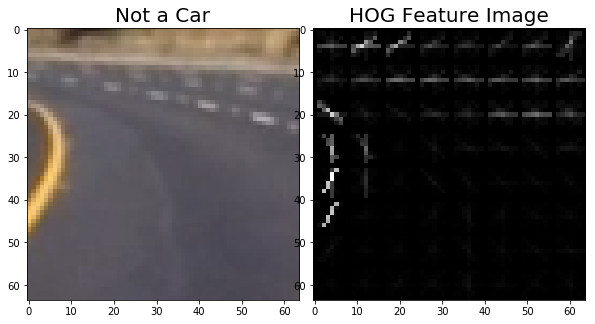

In [6]:
non_car_img = mpimg.imread(not_cars[3])
hog_image = cv2.cvtColor(non_car_img,cv2.COLOR_RGB2YCrCb)
hog_features,output_img = get_hog_features(hog_image[:,:,0],orient, pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=True)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,10))
f.subplots_adjust(hspace = .2, wspace=.05)
ax1.imshow(non_car_img)
ax1.set_title('Not a Car', fontsize=20)
ax2.imshow(output_img)
ax2.set_title('HOG Feature Image', fontsize=20)
plt.imshow(output_img,cmap='gray')
fig.tight_layout()


## Spatial Binning

In [7]:
def bin_spatial(img, size=(32, 32)):
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features
test_img = mpimg.imread(test_images[0])
bin_spatial_features = bin_spatial(test_img,size = (16,16))

## Color Histogram

In [8]:
# Define a function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features



## Extracting features from  training dataset

**2. Explain how you settled on your final choice of HOG parameters.**

This function is used to extract HOG,spatial binning and color histogram features from all the training images.

I have used the following features to extracted from training data set -
* HOG Features
* Color Histogram
* Spatial binning

The function accepts the image path of training data set and parameters to extract features.
I have explored HSV,HSL,YUV and RGB colorspace with different orientations and pixels per block before finalizing my values for the pipeline.
The values that I have finally used to train the dataset are as follows-

**HOG Feature parameters**
* Colorspace - YCrCb
* Number of orientations - 8
* Number of pixels per cell - 8
* Number of cells per block - 2
* Channel - ALL

**Spatial Binning**
* Resize Dimensions - (16,16)

**Color Histogram**
* Number of histogram bins - 32


In [9]:
# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = cv2.cvtColor(cv2.imread(file), cv2.COLOR_BGR2RGB)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    #print(features[0])
    # Return list of feature vectors
    return features

### Performing feature extraction on training images

In [10]:
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 8 # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off

t=time.time() # Start time

car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

notcar_features = extract_features(not_cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
#print('car_features : ',len(car_features))
#print('notcar_features : ',len(notcar_features))

## Splitting train and test data

In this cell, all the features extracted from car and non-car images are stacked together to create feature vector and label vector.
Then, the data is randomly divided into training and test set by ratio of 20% of test set and 80% of training set

In [14]:
# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=rand_state)



## Normalizing the data

Before training the data set,it is important to normalize the feature vectors.

In [15]:
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X_train)
# Apply the scaler to X
X_train = X_scaler.transform(X_train)
X_test = X_scaler.transform(X_test)


## Train Classifier and check accuracy

**3. Describe how (and identify where in your code) you trained a classifier using your selected HOG features (and color features if you used them).**

In this cell, I have trained a Linear SVM classifier with default classifier parameters and feature vectors containing HOG,Spatial and color histogram features.

I have achieved test accuracy of **98.66 %**.

In [16]:
print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()

Using: 8 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 5568
17.35 Seconds to train SVC...
Test Accuracy of SVC =  0.9866


## Sliding Window Search

**1. Describe how (and identify where in your code) you implemented a sliding window search. How did you decide what scales to search and how much to overlap windows?**

I have first used sliding window search to detect cars in images. In the below function sliding_window and search_window , all the windows are calculated and then feature extraction is perfromed on each window individually.
I have not used this function in my final pipeline as it was very time consuming. Instead I have used HOG Sub sampling which is discussed in later section.

The scales and overlap window is discussed in HOG sub sampling cell.

In [17]:
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

## Draw boxes in images

In [18]:
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

## Extracting features of test image

In [19]:
def single_img_features(img, color_space, spatial_size,
                        hist_bins, orient, 
                        pix_per_cell, cell_per_block, hog_channel,
                        spatial_feat, hist_feat, hog_feat):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

## Search windows on test image to find cars

In [20]:
# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #print('features',features)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #print('test_features',test_features)
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #print('prediction',prediction)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows
    

# A function to show an image
def show_img(img):
    if len(img.shape)==3: #Color BGR image
        plt.figure()
        plt.imshow(img)
    else: # Grayscale image
        plt.figure()
        plt.imshow(img, cmap='gray')

### Peforming Sliding search window function to find car in test image

281.34 Seconds to process test images


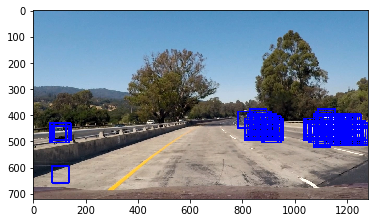

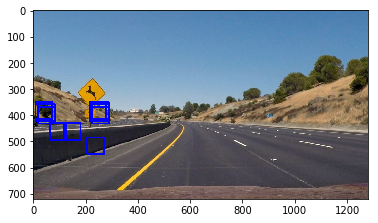

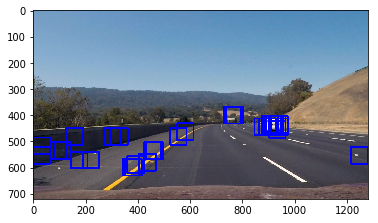

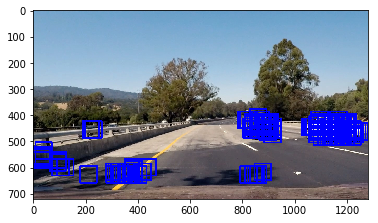

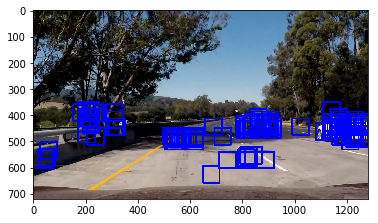

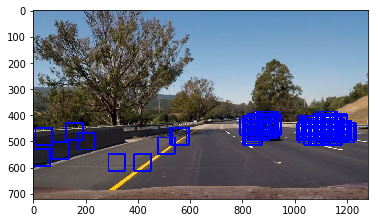

In [21]:
for image_p in glob.glob('test_images/test*.jpg'):
    image = cv2.cvtColor(cv2.imread(image_p),cv2.COLOR_BGR2RGB)
    draw_image = np.copy(image)
    windows = slide_window(image, x_start_stop=[None, None], y_start_stop=[350, 656], 
                    xy_window=(64, 64), xy_overlap=(0.85, 0.85))
    hot_windows = []
    hot_windows += (search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat))                       
    window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)                    
    show_img(window_img)
print(round(time.time()-t, 2), 'Seconds to process test images')

## Hog Sub sampling

**2. Show some examples of test images to demonstrate how your pipeline is working. What did you do to optimize the performance of your classifier?**

I have used HOG Subsampling in my final pipeline.
Instead of extracting features in all the windows,it extracts features in whole image and then full image features are subsampled according to window size.

HOG Sub sampling improved the performance of my classifier.

I tried different scales of 1,1.5 and 2 with overlapping values of 0.5,0.75 and 0.85  before finalizing my final values of scale 1.5 and overalap value of 0.85 which gave the best result for my pipeline.

In [22]:
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins,cspace):
    
    if cspace != 'RGB':
        if cspace == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif cspace == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif cspace == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif cspace == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif cspace == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img) 
    
    ctrans_tosearch = feature_image[ystart:ystop,:,:]
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    all_windows = []
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            #######################
            #test_feature = X_scaler.transform(hog_features.reshape(1,-1))
            #test_prediction = svc.predict(test_feature)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                all_windows.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                
    return all_windows


### Performing HOG Sampling function

327.96 Seconds to process test images


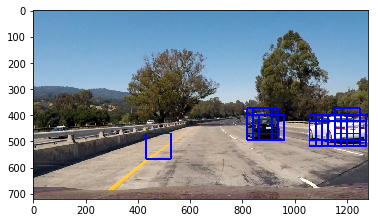

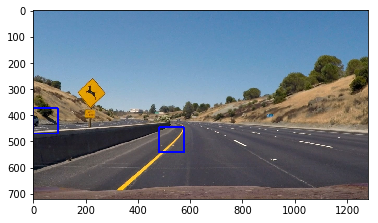

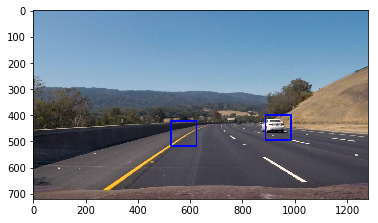

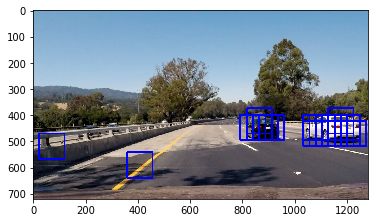

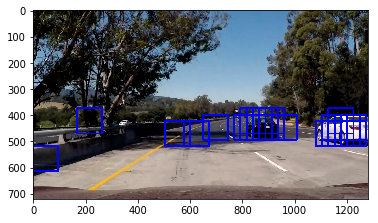

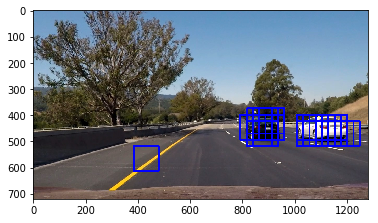

In [23]:
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 8 # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off'''
y_start = 350
y_stop = 656
scale = 1.5

for image_p in glob.glob('test_images/test*.jpg'):
    image = cv2.cvtColor(cv2.imread(image_p),cv2.COLOR_BGR2RGB)
    draw_image = np.copy(image)
    windows = find_cars(image,y_start,y_stop,scale,svc,X_scaler,orient, pix_per_cell, cell_per_block, spatial_size, hist_bins,color_space)                       
    window_img = draw_boxes(draw_image, windows, color=(0, 0, 255), thick=6)                    
    show_img(window_img)
print(round(time.time()-t, 2), 'Seconds to process test images')

## Heat map

Heat map is used majorly to tackle false positives and to combine all the boxes in above image.
I have used a threshold of 2 for creating heatmap. High nvalue of thresholding was not detecting cars in proper box.

In [24]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        if(bbox[0][0] >= 700):
            x_diff = bbox[1][0] - bbox[0][0]
            y_diff = bbox[1][1] - bbox[1][0]
            if(bbox[1][1] > 500 and x_diff <100):
                continue
            cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

### Using Heat map with HOG Sampling function

350.13 Seconds to process test images


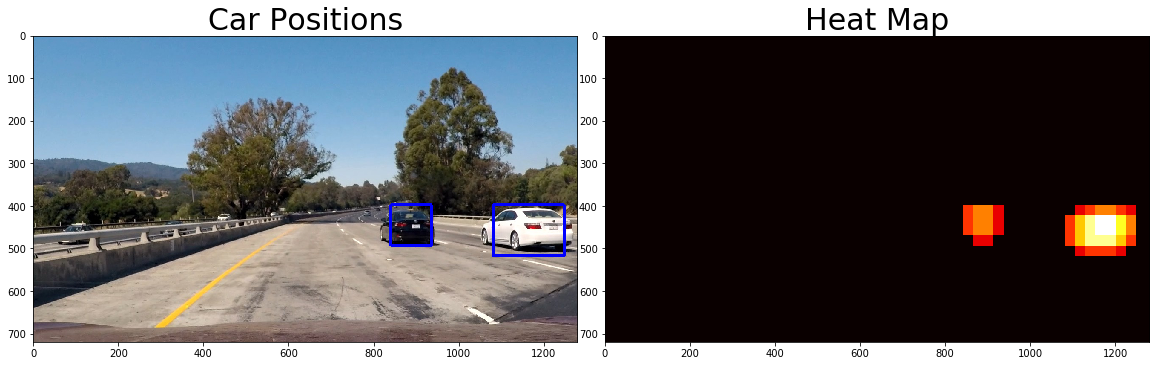

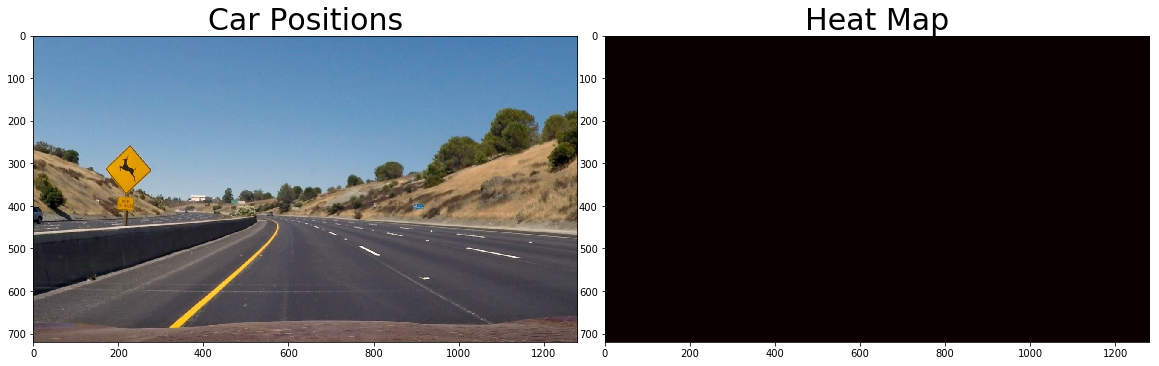

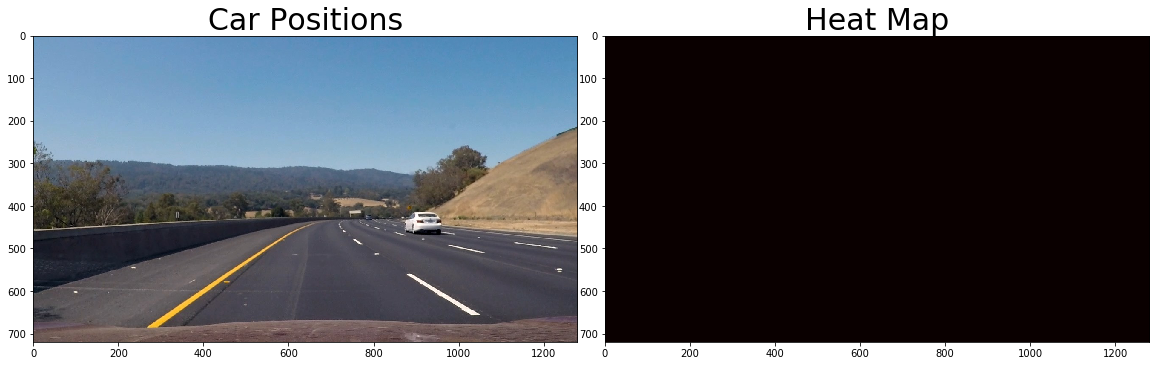

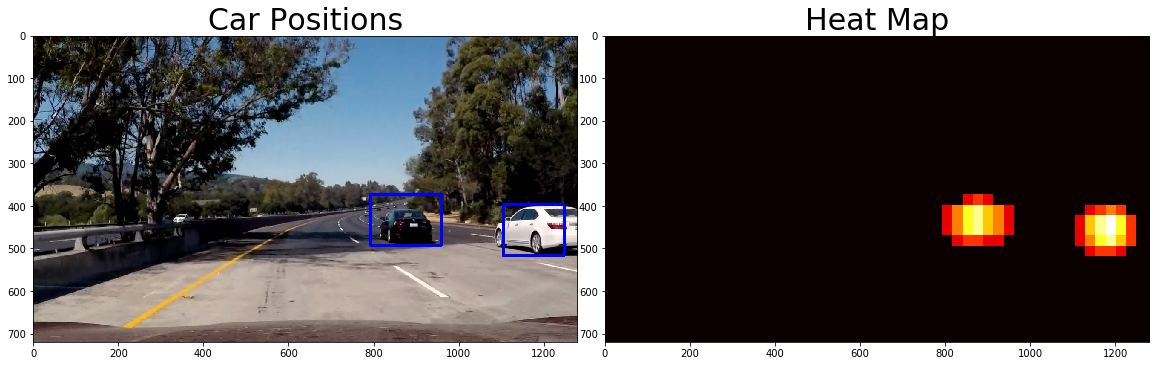

In [25]:
for image_p in glob.glob('test_images/test*.jpg'):
    image = cv2.cvtColor(cv2.imread(image_p),cv2.COLOR_BGR2RGB)
    #image_heat = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    #heat = np.zeros(image.shape)
    draw_image = np.copy(image)
    windows = find_cars(image,y_start,y_stop,scale,svc,X_scaler,orient, pix_per_cell, cell_per_block, spatial_size, hist_bins,color_space)                       
       
    # Add heat to each box in box list
    heat = add_heat(heat,windows)
    
    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,2)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    #print(labels[1])
    draw_img = draw_labeled_bboxes(draw_image, labels)
    #window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)                    
    #show_img(window_img)
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    f.subplots_adjust(hspace = .2, wspace=.05)
    ax1.imshow(draw_img)
    ax1.set_title('Car Positions', fontsize=30)
    ax2.imshow(heatmap, cmap='hot')
    ax2.set_title('Heat Map', fontsize=30)
    #plt.imshow(output_img,cmap='gray')'''
print(round(time.time()-t, 2), 'Seconds to process test images')


## Video pipeline

**1. Provide a link to your final video output. Your pipeline should perform reasonably well on the entire project video (somewhat wobbly or unstable bounding boxes are ok as long as you are identifying the vehicles most of the time with minimal false positives.)**
The output video is saved as 'output_video.mp4' in folder.

**2. Describe how (and identify where in your code) you implemented some kind of filter for false positives and some method for combining overlapping bounding boxes.**

In my pipeline, I have applied thresholding of  2 on heatmap  averaged over 4  previous frames to eliminate false positives.
I have used averaging of previous frames as using heatmap of just current frame was not performing good on video.
I explored averaging on various frames before settling for 4 frames.



In [26]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML
from functools import reduce  

In [28]:
class History_Heatmap():
    def __init__(self):
        self.history=[]
        
previous_frames = 4
history = History_Heatmap()
def pipeline_video(image):
    #image_heat = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    #heat = np.zeros(image.shape)
    draw_image = np.copy(image)
    windows = find_cars(image,y_start,y_stop,scale,svc,X_scaler,orient, pix_per_cell, cell_per_block, spatial_size, hist_bins,color_space)                       
       
    # Add heat to each box in box list
    heat = add_heat(heat,windows)
    
    if len (history.history) > previous_frames:
        history.history = history.history[1:]
    history.history.append(heat)
    heat_history = reduce(lambda h, acc: h + acc, history.history)/previous_frames
    
    # Apply threshold to help remove false positives
    heatmap = apply_threshold(heat_history,2)

    # Visualize the heatmap when displaying    
    #heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    #print(labels[1])
    draw_img = draw_labeled_bboxes(draw_image, labels)
    return draw_img

output_vid = 'output_video.mp4'
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("./project_video.mp4")
white_clip = clip1.fl_image(pipeline_video) #NOTE: this function expects color images!!
%time white_clip.write_videofile(output_vid, audio=False)

[MoviePy] >>>> Building video output_video.mp4
[MoviePy] Writing video output_video.mp4


100%|█████████████████████████████████████▉| 1260/1261 [17:53<00:00,  1.17it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_video.mp4 

Wall time: 17min 54s


### Briefly discuss any problems / issues you faced in your implementation of this project. Where will your pipeline likely fail? What could you do to make it more robust?

The problems I faced during implementation was on first on deciding colorspace and orientation for the HOG features.
Then, Sliding window was taking lot of time.So, I used HOG sampling instead for better performance.
My accuracy was quite high,still more false positives were found in image.
This was handled by heatmap and averaging over past frames.

The pipeline may fail in different lightining conditions or detecting cars which arever far.

The pipeline could be more robust by using different window sizes over different areas. Using Deep Neural network instead of traditional SVM approach.